In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "/content/drive/MyDrive/largedataset/"
IMG_SIZE = 224 
BATCH_SIZE = 32
EPOCHS = 30
CLASS_NAMES = ['no', 'yes']

In [ ]:
def create_image_dataframe(data_path):
    image_paths = []
    labels = []

    for class_name in CLASS_NAMES:
        class_dir = os.path.join(data_path, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            image_paths.append(img_path)
            labels.append(class_name)

    return pd.DataFrame({'filepath': image_paths, 'label': labels})

df = create_image_dataframe(DATA_PATH)

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [ ]:
def create_datagen(preprocess_input, augmentation=False):
    if augmentation:
        return ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.9, 1.1]
        )
    else:
        return ImageDataGenerator(preprocessing_function=preprocess_input)

preprocess_input = applications.densenet.preprocess_input

train_datagen = create_datagen(preprocess_input, augmentation=True)
val_datagen = create_datagen(preprocess_input)
test_datagen = create_datagen(preprocess_input)

def create_flow(datagen, dataframe, shuffle=False):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='filepath',
        y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=shuffle,
        classes=CLASS_NAMES
    )

train_generator = create_flow(train_datagen, train_df, shuffle=True)
val_generator = create_flow(val_datagen, val_df)
test_generator = create_flow(test_datagen, test_df)

Found 2100 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.


In [ ]:
def create_densenet121_model():
    base_model = applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False  

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    return model

model = create_densenet121_model()

In [33]:
callbacks = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_densenet121.h5', save_best_only=True),
    callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

In [34]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7228 - loss: 0.6157 - precision: 0.7236 - recall: 0.7316

66/66 ━━━━━━━━━━━━━━━━━━━━ 535s 8s/step - accuracy: 0.7241 - loss: 0.6131 - precision: 0.7248 - recall: 0.7327 - val_accuracy: 0.8733 - val_loss: 0.3036 - val_precision: 0.8415 - val_recall: 0.9200 - learning_rate: 0.0010
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9039 - loss: 0.2418 - precision: 0.8947 - recall: 0.9146

66/66 ━━━━━━━━━━━━━━━━━━━━ 494s 7s/step - accuracy: 0.9041 - loss: 0.2417 - precision: 0.8950 - recall: 0.9146 - val_accuracy: 0.8800 - val_loss: 0.2660 - val_precision: 0.8490 - val_recall: 0.9244 - learning_rate: 0.0010
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8997 - loss: 0.2582 - precision: 0.8956 - recall: 0.9003

66/66 ━━━━━━━━━━━━━━━━━━━━ 491s 7s/step - accuracy: 0.8998 - loss: 0.2578 - precision: 0.8958 - recall: 0.9004 - val_accuracy: 0.9133 - val_loss: 0.2302 - val_precision: 0.9346 - val_recall: 0.8889 - learning_rate: 0.0010
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 491s 7s/step - accuracy: 0.9182 - loss: 0.1867 - precision: 0.9213 - recall: 0.9053 - val_accuracy: 0.8022 - val_loss: 0.4320 - val_precision: 0.7194 - val_recall: 0.9911 - learning_rate: 0.0010
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9094 - loss: 0.2162 - precision: 0.9029 - recall: 0.9174

66/66 ━━━━━━━━━━━━━━━━━━━━ 498s 7s/step - accuracy: 0.9095 - loss: 0.2161 - precision: 0.9030 - recall: 0.9175 - val_accuracy: 0.9244 - val_loss: 0.2026 - val_precision: 0.9484 - val_recall: 0.8978 - learning_rate: 0.0010
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 486s 7s/step - accuracy: 0.9249 - loss: 0.1709 - precision: 0.9318 - recall: 0.9215 - val_accuracy: 0.8978 - val_loss: 0.2250 - val_precision: 0.8456 - val_recall: 0.9733 - learning_rate: 0.0010
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 504s 7s/step - accuracy: 0.9198 - loss: 0.1863 - precision: 0.9143 - recall: 0.9186 - val_accuracy: 0.9133 - val_loss: 0.2045 - val_precision: 0.8720 - val_recall: 0.9689 - learning_rate: 0.0010
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9466 - loss: 0.1476 - precision: 0.9455 - recall: 0.9514

66/66 ━━━━━━━━━━━━━━━━━━━━ 500s 7s/step - accuracy: 0.9465 - loss: 0.1477 - precision: 0.9454 - recall: 0.9513 - val_accuracy: 0.9289 - val_loss: 0.1571 - val_precision: 0.9214 - val_recall: 0.9378 - learning_rate: 0.0010
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9563 - loss: 0.1152 - precision: 0.9596 - recall: 0.9541

66/66 ━━━━━━━━━━━━━━━━━━━━ 485s 7s/step - accuracy: 0.9562 - loss: 0.1154 - precision: 0.9595 - recall: 0.9541 - val_accuracy: 0.9378 - val_loss: 0.1533 - val_precision: 0.9301 - val_recall: 0.9467 - learning_rate: 0.0010
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 499s 7s/step - accuracy: 0.9583 - loss: 0.1109 - precision: 0.9610 - recall: 0.9564 - val_accuracy: 0.9267 - val_loss: 0.1751 - val_precision: 0.9068 - val_recall: 0.9511 - learning_rate: 0.0010
Epoch 11/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 485s 7s/step - accuracy: 0.9545 - loss: 0.1157 - precision: 0.9574 - recall: 0.9513 - val_accuracy: 0.9200 - val_loss: 0.2123 - val_precision: 0.8706 - val_recall: 0.9867 - learning_rate: 0.0010
Epoch 12/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 484s 7s/step - accuracy: 0.9572 - loss: 0.1163 - precision: 0.9524 - recall: 0.9610 - val_accuracy: 0.9289 - val_loss: 0.2021 - val_precision: 0.8907 - val_recall: 0.9778 - learning_rate: 0.0010
Epoch 13/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 497s 7s/step - accuracy: 0.9643 - los

66/66 ━━━━━━━━━━━━━━━━━━━━ 489s 7s/step - accuracy: 0.9748 - loss: 0.0776 - precision: 0.9670 - recall: 0.9837 - val_accuracy: 0.9444 - val_loss: 0.1471 - val_precision: 0.9237 - val_recall: 0.9689 - learning_rate: 1.0000e-04
Epoch 15/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9732 - loss: 0.0708 - precision: 0.9812 - recall: 0.9631

66/66 ━━━━━━━━━━━━━━━━━━━━ 489s 7s/step - accuracy: 0.9732 - loss: 0.0708 - precision: 0.9813 - recall: 0.9632 - val_accuracy: 0.9444 - val_loss: 0.1352 - val_precision: 0.9274 - val_recall: 0.9644 - learning_rate: 1.0000e-04
Epoch 16/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 496s 7s/step - accuracy: 0.9755 - loss: 0.0709 - precision: 0.9751 - recall: 0.9767 - val_accuracy: 0.9467 - val_loss: 0.1370 - val_precision: 0.9277 - val_recall: 0.9689 - learning_rate: 1.0000e-04
Epoch 17/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 482s 7s/step - accuracy: 0.9789 - loss: 0.0679 - precision: 0.9764 - recall: 0.9811 - val_accuracy: 0.9467 - val_loss: 0.1383 - val_precision: 0.9277 - val_recall: 0.9689 - learning_rate: 1.0000e-04
Epoch 18/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9767 - loss: 0.0708 - precision: 0.9725 - recall: 0.9814

66/66 ━━━━━━━━━━━━━━━━━━━━ 508s 7s/step - accuracy: 0.9767 - loss: 0.0708 - precision: 0.9726 - recall: 0.9814 - val_accuracy: 0.9533 - val_loss: 0.1269 - val_precision: 0.9397 - val_recall: 0.9689 - learning_rate: 1.0000e-04
Epoch 19/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 488s 7s/step - accuracy: 0.9790 - loss: 0.0670 - precision: 0.9761 - recall: 0.9826 - val_accuracy: 0.9467 - val_loss: 0.1291 - val_precision: 0.9313 - val_recall: 0.9644 - learning_rate: 1.0000e-04
Epoch 20/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 498s 8s/step - accuracy: 0.9831 - loss: 0.0619 - precision: 0.9847 - recall: 0.9820 - val_accuracy: 0.9467 - val_loss: 0.1310 - val_precision: 0.9277 - val_recall: 0.9689 - learning_rate: 1.0000e-04
Epoch 21/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 500s 8s/step - accuracy: 0.9771 - loss: 0.0698 - precision: 0.9780 - recall: 0.9758 - val_accuracy: 0.9467 - val_loss: 0.1319 - val_precision: 0.9277 - val_recall: 0.9689 - learning_rate: 1.0000e-04
Epoch 22/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 497s 8s/step - accura

15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.9687 - loss: 0.0723 - precision: 0.9550 - recall: 0.9839

Test Accuracy: 0.9733
Test Loss: 0.0665
Precision: 0.9651
Recall: 0.9822


15/15 ━━━━━━━━━━━━━━━━━━━━ 93s 6s/step

Classification Report:
              precision    recall  f1-score   support

          no       0.98      0.96      0.97       225
         yes       0.97      0.98      0.97       225

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



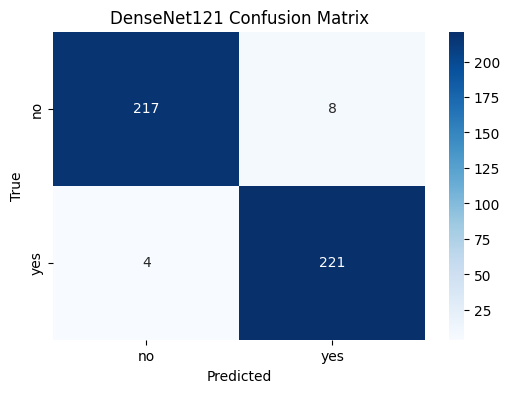

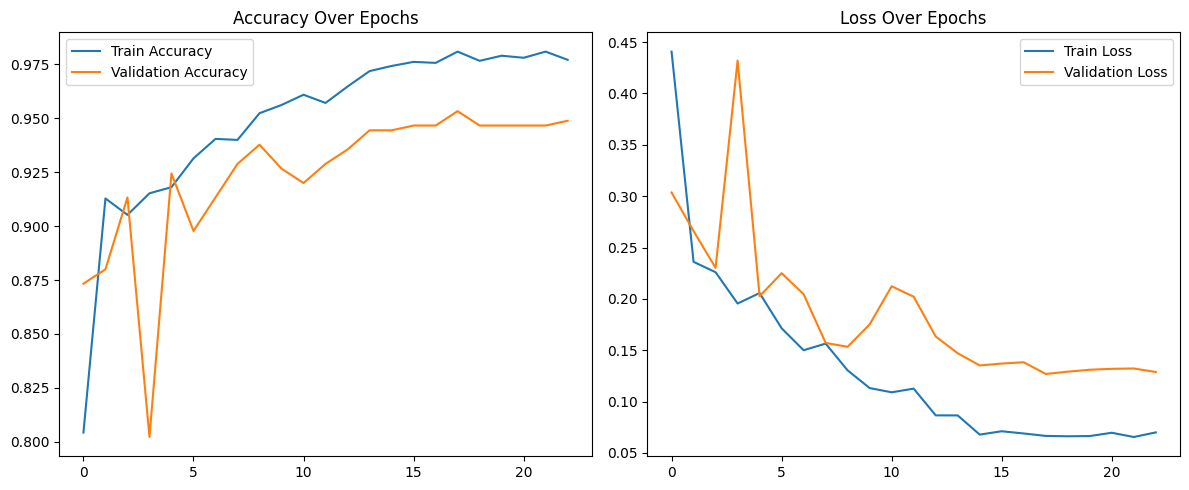

In [ ]:
model.load_weights('best_densenet121.h5')

test_results = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_results[1]:.4f}")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")

y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('DenseNet121 Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()